## Download coade and trained weights

In [1]:
!git clone https://github.com/TapasKumarDutta1/circle_detection.git

Cloning into 'circle_detection'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 33 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (33/33), 13.26 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
!gdown https://drive.google.com/uc?id=1dua5Z4NUhvRtu8wmaN-GqNbl91HUcMFv

Downloading...
From: https://drive.google.com/uc?id=1dua5Z4NUhvRtu8wmaN-GqNbl91HUcMFv
To: /content/weights.pth
100% 5.20M/5.20M [00:00<00:00, 24.6MB/s]


## Import necessary package and point to code to reuse them.

In [4]:
import sys
sys.path.append('/content/circle_detection')
from generate_dataset import generate
from torchvision import models
from torch import nn
import glob
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import CustomDataset
from torch import optim
from torch.optim import lr_scheduler
import torch
from evaluation import check_iou
from training import train_model
import os
generate(10000)


70it [00:00, 694.00it/s]

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


12999it [00:13, 960.25it/s] 


## Create training, validation and testing dataset

In [5]:

path_of_the_directory = "/content/train/labels"
ext = ".txt"
files_train = []
loc_x_train = []
loc_y_train = []
radiuses_train = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_train.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_train.append(int(f.readline()))
        loc_y_train.append(int(f.readline().replace("\n", "")))
        radiuses_train.append(int(f.readline().replace("\n", "")))


In [6]:
path_of_the_directory = "/content/valid/labels"
ext = ".txt"
files_valid = []
loc_x_valid = []
loc_y_valid = []
radiuses_valid = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_valid.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_valid.append(int(f.readline()))
        loc_y_valid.append(int(f.readline().replace("\n", "")))
        radiuses_valid.append(int(f.readline().replace("\n", "")))


In [7]:
path_of_the_directory = "/content/test/labels"
ext = ".txt"
files_test = []
loc_x_test = []
loc_y_test = []
radiuses_test = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_test.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_test.append(int(f.readline()))
        loc_y_test.append(int(f.readline().replace("\n", "")))
        radiuses_test.append(int(f.readline().replace("\n", "")))


## Sanity check

Plot one image and reconstruct the image using the labels(x,y and radius)

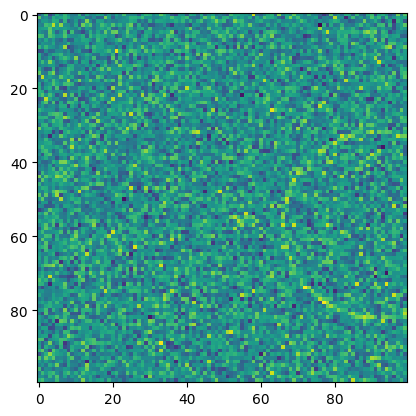

In [35]:
img=np.load("/content/train/images/0.npy")
plt.imshow(img)

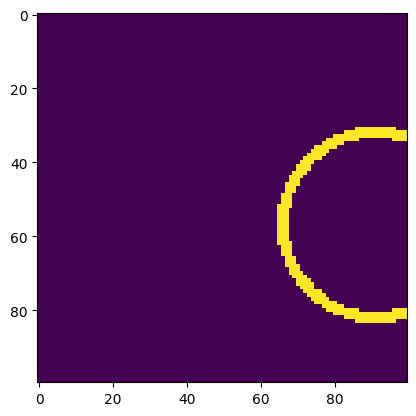

In [38]:
img=np.zeros((100,100))
f = open("/content/train/labels/0.txt", "r")
x=int(f.readline())
y=int(f.readline())
radius=int(f.readline())
cv2.circle(img, (x, y), int(radius), (255,0,0), 2)
plt.imshow(img)

## Trianing

Calculate mean and standard deviation on the triaining set for normalization, create the optimizer, loss, scheduler, and start training.

In [ ]:
ls = []
for i in glob.glob("/content/train/images/*.npy"):
    ls.append(np.load(i, allow_pickle=True))
mean, std = np.mean(np.stack(ls)), np.std(np.stack(ls))

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean, mean, mean), (std, std, std))]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean, mean, mean), (std, std, std))]
)

batch_size = 10

dataset_stages = ["train", "val", "test"]
image_datasets = {
    "train": CustomDataset(
        files_train, loc_x_train, loc_y_train, radiuses_train, batch_size, transform
    ),
    "val": CustomDataset(
        files_valid,
        loc_x_valid,
        loc_y_valid,
        radiuses_valid,
        batch_size,
        test_transform,
    ),
    "test": CustomDataset(
        files_test, loc_x_test, loc_y_test, radiuses_test, batch_size, test_transform
    ),
}

dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=image_datasets[x].BatchSize,
        shuffle=False,
        num_workers=0,
    )
    for x in dataset_stages
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
model = models.shufflenet_v2_x1_0()
model.fc = nn.Linear(in_features=1024, out_features=3, bias=True)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, "min")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model, _ = train_model(
    model,
    dataloaders["train"],
    dataloaders["val"],
    criterion,
    optimizer,
    scheduler,
    device,
    50,
)


100%|██████████| 100/100 [00:02<00:00, 41.77it/s]


Epoch [0], train_loss: 0.0541, val_loss: 0.0040


100%|██████████| 100/100 [00:01<00:00, 55.01it/s]


Epoch [1], train_loss: 0.0053, val_loss: 0.0033


100%|██████████| 100/100 [00:01<00:00, 54.51it/s]


Epoch [2], train_loss: 0.0038, val_loss: 0.0024


100%|██████████| 100/100 [00:01<00:00, 53.41it/s]


Epoch [3], train_loss: 0.0027, val_loss: 0.0021


100%|██████████| 100/100 [00:02<00:00, 49.23it/s]


Epoch [4], train_loss: 0.0029, val_loss: 0.0016


100%|██████████| 100/100 [00:01<00:00, 53.80it/s]


Epoch [5], train_loss: 0.0021, val_loss: 0.0090


100%|██████████| 100/100 [00:02<00:00, 49.34it/s]


Epoch [6], train_loss: 0.0017, val_loss: 0.0016


100%|██████████| 100/100 [00:02<00:00, 40.01it/s]


Epoch [7], train_loss: 0.0009, val_loss: 0.0011


100%|██████████| 100/100 [00:02<00:00, 41.48it/s]


Epoch [8], train_loss: 0.0008, val_loss: 0.0015


100%|██████████| 100/100 [00:01<00:00, 51.21it/s]


Epoch [9], train_loss: 0.0035, val_loss: 0.0025


100%|██████████| 100/100 [00:01<00:00, 53.91it/s]


Epoch [10], train_loss: 0.0013, val_loss: 0.0010


100%|██████████| 100/100 [00:01<00:00, 55.01it/s]


Epoch [11], train_loss: 0.0007, val_loss: 0.0010


100%|██████████| 100/100 [00:01<00:00, 54.72it/s]


Epoch [12], train_loss: 0.0005, val_loss: 0.0008


100%|██████████| 100/100 [00:01<00:00, 55.06it/s]


Epoch [13], train_loss: 0.0005, val_loss: 0.0009


100%|██████████| 100/100 [00:01<00:00, 54.27it/s]


Epoch [14], train_loss: 0.0017, val_loss: 0.0014


100%|██████████| 100/100 [00:02<00:00, 49.95it/s]


Epoch [15], train_loss: 0.0007, val_loss: 0.0007


100%|██████████| 100/100 [00:02<00:00, 48.32it/s]


Epoch [16], train_loss: 0.0005, val_loss: 0.0006


100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Epoch [17], train_loss: 0.0004, val_loss: 0.0007


100%|██████████| 100/100 [00:02<00:00, 46.17it/s]


Epoch [18], train_loss: 0.0005, val_loss: 0.0009


100%|██████████| 100/100 [00:02<00:00, 49.12it/s]


Epoch [19], train_loss: 0.0007, val_loss: 0.0017


100%|██████████| 100/100 [00:01<00:00, 51.72it/s]


Epoch [20], train_loss: 0.0016, val_loss: 0.0013


100%|██████████| 100/100 [00:01<00:00, 55.58it/s]


Epoch [21], train_loss: 0.0006, val_loss: 0.0011
Early stopping after 22 epochs without improvement.
Training complete in 15m 36s


In [11]:
model.load_state_dict(torch.load("/content/weights.pth"))
check_iou(model, dataloaders['test'], device)

0.992

In [12]:
ls=[]
for i in range(50,95,5):
  ls.append(check_iou(model, dataloaders['test'], device,i/100))
np.mean(ls)

0.863

## Visualization

Plot some of the test images and reconstruct using model's predictions.

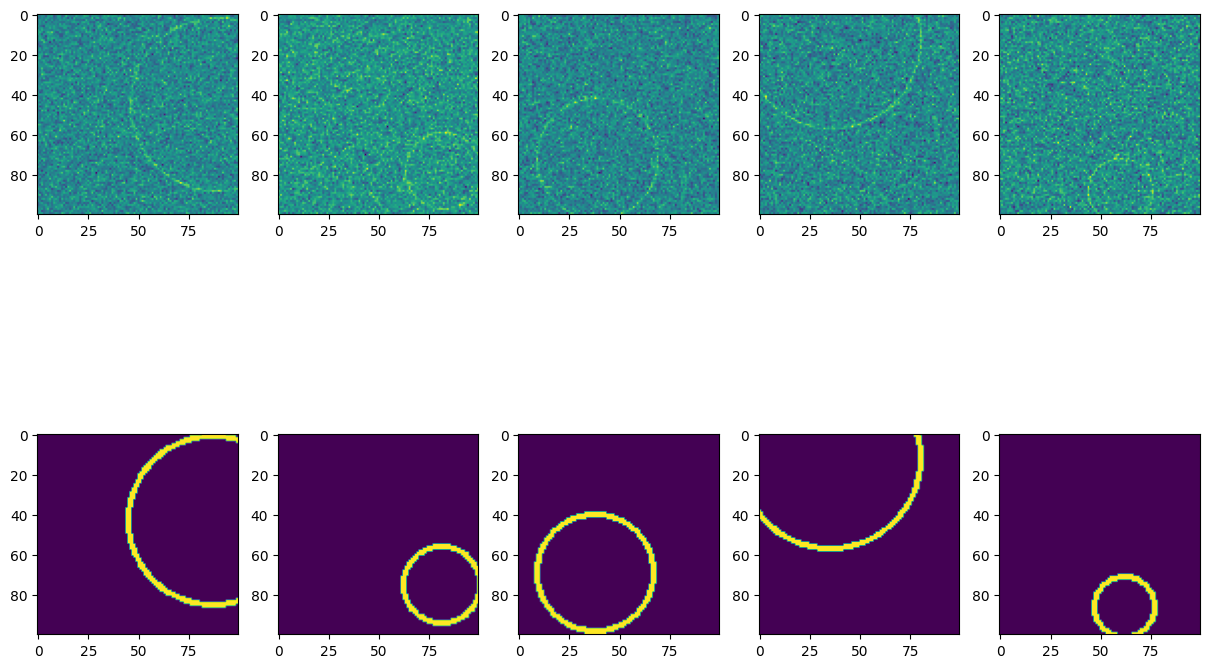

In [34]:
for images in dataloaders['test']:
  break
fig,ax = plt.subplots(2,5, figsize=(15,10))
for i in range(5):
    ax[0][i].imshow(images[0][i,0])
    x,y,r=pred[i].detach().cpu().numpy()*[100,100,49]
    x,y,r=int(x),int(y),int(r)
    img=np.zeros((100,100))
    cv2.circle(img, (int(x), int(y)), int(r), (255,0,0), 2)
    ax[1][i].imshow(img)